In [ ]:
%matplotlib inline

# Recurrent Neural Network

In [ ]:
NAME = "Kenny Bun"

In this assignment you will use Recurrrent Neural Network architecture (and possible variations of it) to solve **one** of the following problems. For the problem you choose, you will have to follow the steps mentioned below.


*   United States Corona Virus Cases Forecast
> In this dataset you will use the data available at https://drive.google.com/file/d/1Y7PDnv5-HfmchT9FmFsGKsM3U6JMEABF to predict the number of positive COVID-19 cases in the USA. Note that the number of COVID-19 cases are cumulative.

*   Reuters Topic Classification
> We will use the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels. You can see what these labels represent [here](https://martin-thoma.com/nlp-reuters/). You will analyze the text and classify the text into one of the 46 classes. Classes are the defined based on the following list (in the same order):
>```
['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']
```





In [ ]:
import numpy as np
import pandas as pd

## Part 1: Reading the data (20 points)
---

In this part you need to:

1) read in the data (for your task)
> * For COVID-19 data you might find this lihnk useful: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92. You need to use the public link to the dataset provided earlier so we can run your code on our end.
> * For Reuters data, you can simply load it from Keras: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data

2) prepare and clean the data 
> * For COVID-19 dataset this means removing attributes you don't need (ex. Lat/Long features),  removing entries that are not relevant to your prediction task (ex. number of cases of other countries), and any other pre-processing you might find useful. 
Depending on your implementation you might find scaling also useful (Recall [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. **Hint**: You will need to call .transpose inorder to comply with required inputshape (n,1)). You might also find it useful to trim the data in the begining as reporting was not accurate on early days (>50,000 cases might be a reasonable cut-off). 
> * For Reuters news classification data, you may follow the RNN handout from the class exercise and prepare encoding and decoding functions and any other pre-processing you might find useful.

3) Sample of the dataset
> * For COVID-19 dataset print the head of your dataframe so we can see what data points and what features you will use for training.
> * For Reuters news classification data, print an example of a news along with its class label. 

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Load data
### YOUR CODE HERE ###
file_id = '1Y7PDnv5-HfmchT9FmFsGKsM3U6JMEABF'
downloaded = drive.CreateFile({'id' : file_id})
downloaded.GetContentFile('covid.csv')
covid_data = pd.read_csv('covid.csv')

# Clean and pre-process the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

### YOUR CODE HERE ###
us_covid_data = covid_data.loc[covid_data['Country/Region']=='US',:]
us_covid_data.drop(columns=['Province/State','Country/Region','Lat','Long'],inplace=True)
us_covid_data_array_ge50k = us_covid_data.values.reshape(-1,1)[us_covid_data.values.reshape(-1,1)>=50000]

print(us_covid_data_array_ge50k.shape)
scaler.fit(us_covid_data_array_ge50k.reshape(-1,1))
print(scaler.data_max_)

# Print sample data

### YOUR CODE HERE ###
us_covid_data_scaled = scaler.transform(us_covid_data_array_ge50k.reshape(-1,1))
us_covid_data_scaled[:5]

(341,)
[28554465.]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


array([[0.        ],
       [0.00042396],
       [0.00105054],
       [0.00170638],
       [0.00239521]])

4) An additional step for COVID-19 data
>You need to modify your dataset so you determine how many days back the model will look to generate a new prediction. Begin with time_step=2. In the training phase you can choose different time-steps (and modify the architecture accordingly).

In [ ]:
# You may use the following function to process your dataset further.
# Generate a dataset where X[n] contains the readings for the 'time_step' previous days 
# and y contains the reading for today.
def create_dataset(dataset, time_steps=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_steps-1):
		a = dataset[i:(i+time_steps), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_steps, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# Choose the number of time steps that the model "looks back"
time_steps = 20

# Produce your dataset based on the number of days the model could look back

### YOUR CODE HERE ###
covid_X, covid_Y = create_dataset(us_covid_data_scaled.reshape(-1,1),time_steps=time_steps)

# Print head of the data

### YOUR CODE HERE ###
us_covid_data_scaled = scaler.transform(us_covid_data_array_ge50k.reshape(-1,1))
us_covid_data_scaled[:5]

array([[0.        ],
       [0.00042396],
       [0.00105054],
       [0.00170638],
       [0.00239521]])

## Part 2: Data Partitioning (5 points)
---
Split data into train and test sets. Please use 80\% for training and 20\% for testing. Note: 
> * for COVID-19 dataset you need to split the data in time (the begining 80\% of the days from start date will be the training data and the remaining 20\% will be test data).
> * for Reuters dataset, we want to have the same distribution of labels in the training and test set, so you can simply use stratified train-test split of Keras. See here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html 

In [ ]:
### YOUR CODE HERE ###
train_size = 0.80
idxs = int(len(covid_X)*train_size)
X_train, X_test, y_train, y_test = covid_X[:idxs], covid_X[idxs:], covid_Y[:idxs], covid_Y[idxs:]

For COVID-19 dataset, you need to reshape the partitions for the model to be able to process them.

In [ ]:
# Reshape input to be [samples, time steps, features]. For example:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Part 3: Simple RNN Model (25 points)
---

In this part you will create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss and your metric (accuracies (for Reuters data) and mean squared error (for COVID-19 data)).

Compile your model and display the summary:

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model

In [ ]:
# Build your model

### YOUR CODE HERE ###
input_layer = Input(shape=(1,time_steps))

x = LSTM(64)(input_layer)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='relu')(x)
model = Model(input_layer, x)

loss = tf.keras.losses.MeanSquaredError()

opt = tf.keras.optimizers.Adam(2e-4)

metrics = 'mean_squared_error'

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 20)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                21760     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 28,033
Trainable params: 28,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batchsize = 256
epochs =  100

# Fit model
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.2386 - val_mean_squared_error: 0.2386
Epoch 2/100
1/1 [==============================] - 0s 54ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.2386 - val_mean_squared_error: 0.2386
Epoch 3/100
1/1 [==============================] - 0s 50ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.2386 - val_mean_squared_error: 0.2386
Epoch 4/100
1/1 [==============================] - 0s 51ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.2386 - val_mean_squared_error: 0.2386
Epoch 5/100
1/1 [==============================] - 0s 54ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.2386 - val_mean_squared_error: 0.2386
Epoch 6/100
1/1 [==============================] - 0s 53ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.2386 - val_mean_squared_error: 0.2386
Epoch 7/100
1/1 [=========================

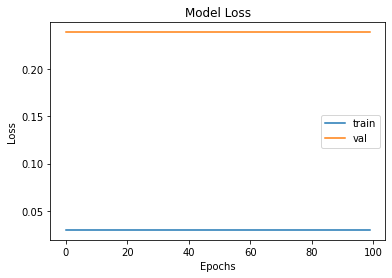

In [ ]:
# Plot the Model loss

### YOUR CODE HERE ###
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

## Part 4: More Advanced RNN Model (30 points)
---
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss and your metric (accuracies (for Reuters data) and mean squared error (for COVID-19 data)). In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model

In [ ]:
# Build your model

### YOUR CODE HERE ###
input_layer = Input(shape=(1,time_steps))

x2 = LSTM(64, return_sequences=True)(input_layer)
x2 = LSTM(32, return_sequences=True)(x2)
# x2 = LSTM(16, return_sequences=True)(x2)
x2 = LSTM(8)(x2)
x2 = Dense(64, activation='relu')(x2)
x2 = Dense(32, activation='relu')(x2)
#x2 = Dense(16, activation='relu')(x2)
x2 = Dense(1, activation='relu')(x2)
model = Model(input_layer, x2)

loss = tf.keras.losses.MeanSquaredError()

opt = tf.keras.optimizers.Adam(2e-4)

metrics = 'mean_squared_error'

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 20)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             21760     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)             12416     
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33  

In [ ]:
batchsize = 170
epochs =  80

# Fit model
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/80
2/2 [==============================] - 6s 1s/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.2345 - val_mean_squared_error: 0.2345
Epoch 2/80
2/2 [==============================] - 0s 50ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.2317 - val_mean_squared_error: 0.2317
Epoch 3/80
2/2 [==============================] - 0s 48ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.2290 - val_mean_squared_error: 0.2290
Epoch 4/80
2/2 [==============================] - 0s 55ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.2263 - val_mean_squared_error: 0.2263
Epoch 5/80
2/2 [==============================] - 0s 51ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.2235 - val_mean_squared_error: 0.2235
Epoch 6/80
2/2 [==============================] - 0s 52ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - val_loss: 0.2208 - val_mean_squared_error: 0.2208
Epoch 7/80
2/2 [==============================] 

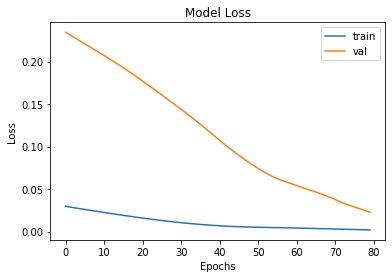

In [ ]:
# Plot the Model loss

### YOUR CODE HERE ###
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

## Part 5: Looking at the Predictions (20 points)
---

Now, Using the final (best) model you trained, show your model's performance on the test set.
> * For COVID-19 dataset, plot the model's prediction for the number of cases and the actual daily cumulative case numbers.
> * For Reuters dataset, calculate and display the prediction accuracy for all of the 46 different classes. 

In [ ]:
### YOUR CODE HERE ###
y_preds_raw = model.predict(X_test)
print(y_preds_raw)
mean_test_loss = np.mean(tf.keras.losses.MSE(y_preds_raw, y_test))
print(f'Test Loss = {mean_test_loss}')
y_preds = scaler.inverse_transform(y_preds_raw)

[[0.43165287]
 [0.43544608]
 [0.439254  ]
 [0.44306645]
 [0.44673443]
 [0.4503478 ]
 [0.4539463 ]
 [0.45746627]
 [0.46096355]
 [0.4645384 ]
 [0.4681299 ]
 [0.4715608 ]
 [0.47494897]
 [0.4784314 ]
 [0.48185256]
 [0.4853467 ]
 [0.4889041 ]
 [0.4924256 ]
 [0.49591336]
 [0.49936107]
 [0.5028275 ]
 [0.50632274]
 [0.5097905 ]
 [0.51327527]
 [0.51674026]
 [0.52014357]
 [0.5234549 ]
 [0.52666676]
 [0.5298232 ]
 [0.53289837]
 [0.53595287]
 [0.53893524]
 [0.5418233 ]
 [0.54459685]
 [0.5472243 ]
 [0.54973215]
 [0.5521727 ]
 [0.5545575 ]
 [0.55686945]
 [0.5591    ]
 [0.5612239 ]
 [0.5632291 ]
 [0.5651434 ]
 [0.5670229 ]
 [0.5688532 ]
 [0.5706385 ]
 [0.57236016]
 [0.5740089 ]
 [0.5755658 ]
 [0.57706225]
 [0.5785255 ]
 [0.5799535 ]
 [0.5813252 ]
 [0.5826357 ]
 [0.58387876]
 [0.58504623]
 [0.58614826]
 [0.5872343 ]
 [0.5883047 ]
 [0.58932614]
 [0.590314  ]
 [0.5912693 ]
 [0.59217316]
 [0.5930425 ]]
Test Loss = 0.1255661710488251


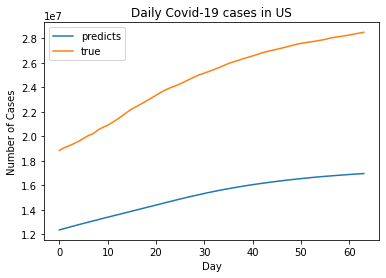

In [ ]:
plt.plot(y_preds, label='predicts')
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)),label='true')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.title('Daily Covid-19 cases in US')
plt.legend()

## Extra Credit: Reuters Topic Classification

*   Reuters Topic Classification
> We will use the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels. You can see what these labels represent [here](https://martin-thoma.com/nlp-reuters/). You will analyze the text and classify the text into one of the 46 classes. Classes are the defined based on the following list (in the same order):
>```
['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']
```

## Part 1: Reading the data (20 points)
---

In this part you need to:

1) read in the data (for your task)
> * For COVID-19 data you might find this lihnk useful: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92. You need to use the public link to the dataset provided earlier so we can run your code on our end.
> * For Reuters data, you can simply load it from Keras: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data

2) prepare and clean the data 
> * For COVID-19 dataset this means removing attributes you don't need (ex. Lat/Long features),  removing entries that are not relevant to your prediction task (ex. number of cases of other countries), and any other pre-processing you might find useful. 
Depending on your implementation you might find scaling also useful (Recall [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. **Hint**: You will need to call .transpose inorder to comply with required inputshape (n,1)). You might also find it useful to trim the data in the begining as reporting was not accurate on early days (>50,000 cases might be a reasonable cut-off). 
> * For Reuters news classification data, you may follow the RNN handout from the class exercise and prepare encoding and decoding functions and any other pre-processing you might find useful.

3) Sample of the dataset
> * For COVID-19 dataset print the head of your dataframe so we can see what data points and what features you will use for training.
> * For Reuters news classification data, print an example of a news along with its class label. 

## Part 2: Data Partitioning (5 points)
---
Split data into train and test sets. Please use 80\% for training and 20\% for testing. Note: 
> * for COVID-19 dataset you need to split the data in time (the begining 80\% of the days from start date will be the training data and the remaining 20\% will be test data).
> * for Reuters dataset, we want to have the same distribution of labels in the training and test set, so you can simply use stratified train-test split of Keras. See here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html 

## Part 3: Simple RNN Model (25 points)
---

In this part you will create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss and your metric (accuracies (for Reuters data) and mean squared error (for COVID-19 data)).

Compile your model and display the summary:

## Part 5: Looking at the Predictions (20 points)
---

Now, Using the final (best) model you trained, show your model's performance on the test set.
> * For COVID-19 dataset, plot the model's prediction for the number of cases and the actual daily cumulative case numbers.
> * For Reuters dataset, calculate and display the prediction accuracy for all of the 46 different classes. 